**CONSIGNAS PARA TODOS LOS EJERCICIOS:**

1.   En el caso de utilizar una Regresión Logística grafique sus parámetros con la función AA_utils.visualizar_parametros
2.   Grafique e interprete la matriz de confusión de la predicción sobre el set de test con la función AA_utils.visualizar_confusion_matrix
3.   Elabore un reporte de métricas tanto para la predicción de train como para la de test con la función AA_utils.print_classification_report
4.   En los casos de clasificación binaria grafique e interprete la curva ROC con la función AA_utils.visualizar_curva_ROC
5.   En los caso de clasificación de dos variables grafique la función de transferencia y la frontera de decisión con las funciones AA_utils.visualizar_funcion_transferencia_2D y AA_utils.visualizar_frontera_de_desicion_2D
6.   En los casos de clasificación binaria de una variable grafique la curva logística con la función AA_utils.visualizar_curva_logistica

# **MODELO DE REGRESIÓN LOGÍSTICA**

***Clasificación con 2 variables***: Entrene modelos de Regresión Logística para clasificar el siguiente dataset:
*   2D_unbalanced.csv

El código “ejemplo_clasificacion_binaria_dos_variables_regresion_logistica.py” posee un ejemplo de cómo realizar esta tarea.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report

from mpl_toolkits.axes_grid1 import make_axes_locatable

# **AA UTILS**

In [ ]:
def if_dataframe_to_numpy(data):
    return data.to_numpy() if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series) else data

def plot_2d(modelo, X, X_train, X_test, y_train, y_test, boundry_function):

    assert X.shape[1] == 2, f"X debe tener solo dos variables de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)
    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    plt.figure()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = np.c_[xx.ravel(), yy.ravel()]
    Z = boundry_function(modelo, Z)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.colorbar()

    plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, label='Training')
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="+", c=y_test, s=80, label='Testing')
    plt.legend()
    plt.show()

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

def visualizar_parametros(modelo, mostrar_bias, feature_names=[], target_name='target'):
    parametros = pd.DataFrame(modelo.coef_, columns=feature_names if len(feature_names) > 0 else range(modelo.coef_.shape[1]))

    if mostrar_bias:
        parametros['bias'] = modelo.intercept_

    parametros.T.plot(kind='bar')

    if hasattr(modelo, 'classes_'):
        if len(modelo.classes_) <= 2:
            plt.legend([target_name])
        else:
            plt.legend(list(modelo.classes_))
    else:
        plt.legend([target_name])

    plt.show()

def visualizar_curva_logistica(modelo, X, y, feature_name='target'):

    assert X.shape[1] == 1, f"X debe tener solo una variable de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)

    plt.figure()
    plt.scatter(X, y, c=y, s=50)
    plt.xlabel(feature_name)
    plt.grid()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_graph = np.linspace(x_min, x_max)
    y_graph = modelo.predict_proba(x_graph.reshape(-1, 1))[:, 1]
    plt.plot(x_graph, y_graph)
    plt.show()

def visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test):
    plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict(Z))

def visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test):

    if hasattr(modelo, 'predict_proba') and callable(getattr(modelo, 'predict_proba')):
        plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict_proba(Z)[:, 1])
    else:
        raise ValueError("no se puede visualizar funcion de transferencia")

def visualizar_confusion_matrix(real_target, pred_target,
                                classes=[],
                                normalize=False,
                                title='Matriz de confusión',
                                cmap=plt.cm.Blues):

    if (len(classes) == 0):
        classes = [str(i) for i in range(int(max(real_target) + 1))]  # nombres de clases consecutivos

    cm = confusion_matrix(real_target, pred_target)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def visualizar_curva_ROC(modelo, X, y):

    assert len(set(y)) <= 2, f"El dataset debe ser binario (hay {len(set(y))}) clases"

    y_score = modelo.predict_proba(X)[:, 1]  # se queda con la clase 1

    false_positive_rate, true_positive_rate, threshold = roc_curve(y, y_score)

    precision, recall, _ = precision_recall_curve(y, y_score)

    # ROC
    plt.figure()
    plt.title('ROC. Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (1- Especificidad)')
    plt.show()

    # precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()

def elegir_imagen_al_azar(X, pixeles_ancho, pixeles_alto):
    indice = np.random.randint(0, X.shape[0])
    img_i = np.reshape(X[indice, :], (pixeles_ancho, pixeles_alto))
    plt.figure()
    plt.imshow(img_i, 'gray')
    plt.title('Dato aleatorio')
    plt.show()
    return X[indice].reshape(1, -1), indice

def visualizar_parametros_para_imagenes(modelo, cantidad_de_clases, pixeles_ancho=28, pixeles_alto=28):

    if hasattr(modelo, 'coef_'):
        w = modelo.coef_
    elif hasattr(modelo, 'coefs_') and (modelo.coefs_) == 1:
        w = modelo.coefs_[0]
    else:
        raise "para visualizar los parametros de la red es necesario tener cero capas ocultas"

    colorbar_max = np.abs(np.max(w))
    w_r = np.reshape(w, (cantidad_de_clases, pixeles_ancho, pixeles_alto))
    fig, ax = plt.subplots(2, cantidad_de_clases // 2)
    plt.suptitle('Coeficientes aprendidos para cada clase, \nagrupados en forma matricial de 28x28')
    index = 0
    for row in range(0, 2):
        for col in range(0, cantidad_de_clases // 2):
            colorbar_max = max(np.abs(np.max(w_r[index, :, :])), np.abs(np.min(w_r[index, :, :])))
            ax_im = ax[row][col].imshow(w_r[index, :, :], cmap='seismic', vmin=-colorbar_max, vmax=colorbar_max)
            ax[row][col].get_xaxis().set_visible(False)
            ax[row][col].get_yaxis().set_visible(False)
            ax[row][col].set_title(str(index))
            divider = make_axes_locatable(ax[row][col])
            cax = divider.append_axes("right", size="5%", pad=0.05)

            fig.colorbar(ax_im, ax=ax[row][col], cax=cax)
            index += 1
    plt.show()

def visualizar_ajuste_por_regresion(modelo, X_train, X_test, y_train, y_test,
                                    feature_name='X', target_name='target'):
    plt.scatter(X_train, y_train, c='blue', s=40, alpha=0.9, label='Training')
    plt.scatter(X_test, y_test, c='red', s=50, alpha=0.5, label='Testing')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.legend()
    plt.grid()

    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    x_max = max(max(X_train), max(X_test))
    x_min = min(min(X_train), min(X_test))

    x_plot = np.linspace(x_min, x_max, 100)
    y_plot = modelo.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, 'g--', linewidth=5)
    plt.show()

def visualizar_curva_error_entrenamiento(modelo):
    plt.plot(modelo.loss_curve_)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Train'])
    plt.show()


# **2D_UNBALANCED**

**CARGA DE DATOS**

In [ ]:
data = pd.read_csv(r"https://raw.githubusercontent.com/KevinFDI/IML_Practica_3/main/Pr%C3%A1ctica/datasets/2D_unbalanced.csv")

Hago una vista rápida del dataset.

In [ ]:
round(data.head(5), 2)

,feature1,feature2,target
0,-1.07,-1.33,0.0
1,-1.14,1.66,0.0
2,-0.57,-0.96,0.0
3,-1.06,-1.56,0.0
4,-0.67,1.44,0.0


Analizo si tiene nulos el dataset.

In [ ]:
data.isnull().sum()

feature1    0
feature2    0
target      0
dtype: int64

Grafico un histograma

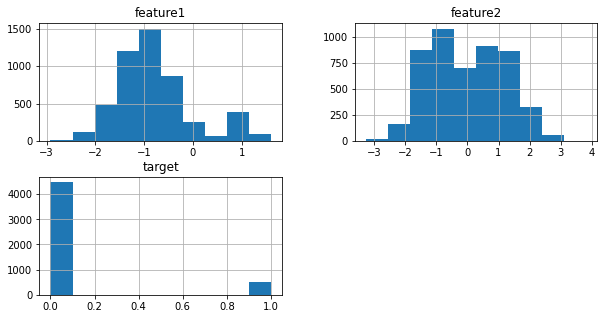

In [ ]:
data.hist(figsize=(10,5));

**PREPROCESADO**

In [ ]:
X = data.drop(columns=['target'])
y = data['target']

print(f'''
      ====================================================================================================
      El problema de clasificación es de {X.shape[1]} features ---(prediciendo)---> {len(set(y))} clases
      ====================================================================================================
      ''')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NORMALIZAR = True

if NORMALIZAR:
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


      El problema de clasificación es de 2 features ---(prediciendo)---> 2 clases
      


**MODELADO**

In [ ]:
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

LogisticRegression()

EVALUACION

MÉTRICAS SOBRE EL CONJUNTO DE TRAINING

In [ ]:
print_classification_report(y_train, modelo.predict(X_train))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3583
         1.0       0.95      0.94      0.95       417

    accuracy                           0.99      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.99      0.99      0.99      4000



MÉTRICAS SOBRE EL CONJUNTO DE TESTING

In [ ]:
print_classification_report(y_test, modelo.predict(X_test))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       892
         1.0       0.96      0.94      0.95       108

    accuracy                           0.99      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.99      0.99      0.99      1000



MATRIZ DE CONFUSIÓN

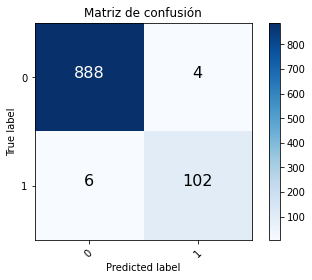

In [ ]:
visualizar_confusion_matrix(y_test, modelo.predict(X_test))

En este caso el dataset está muy desbalanceado (cuanta con una clase que es mayoritaria).

Una opción para solucionar el problema del desbalance de clases es con el parámetro class_weight.

In [ ]:
# CAMBIO DEL PARÁMETRO CLASS_WEIGHT

from sklearn.utils import class_weight

weights = {0:0.05, 1:0.95} # Determina si tengo más falsos positivos o más falsos positivos
modelo_2 = LogisticRegression(class_weight=weights)
modelo_2.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.05, 1: 0.95})

In [ ]:
# 3

print("\t      MÉTRICAS SOBRE EL CONJUNTO DE TRAINING")
print_classification_report(y_train, modelo_2.predict(X_train))

print("\n\t      MÉTRICAS SOBRE EL CONJUNTO DE TESTING")
print_classification_report(y_test, modelo_2.predict(X_test))

	      MÉTRICAS SOBRE EL CONJUNTO DE TRAINING
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      3583
         1.0       0.61      0.95      0.74       417

    accuracy                           0.93      4000
   macro avg       0.80      0.94      0.85      4000
weighted avg       0.95      0.93      0.94      4000


	      MÉTRICAS SOBRE EL CONJUNTO DE TESTING
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       892
         1.0       0.58      0.94      0.72       108

    accuracy                           0.92      1000
   macro avg       0.79      0.93      0.84      1000
weighted avg       0.95      0.92      0.93      1000



Con el cambio en el parámetro de class_weight se observa como la presición del modelo disminuye de forma significativa para 1.

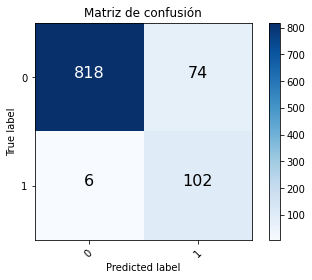

In [ ]:
# 2

visualizar_confusion_matrix(y_test, modelo_2.predict(X_test))

CURVA DE ROC Y DE PRECISION-RECALL

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


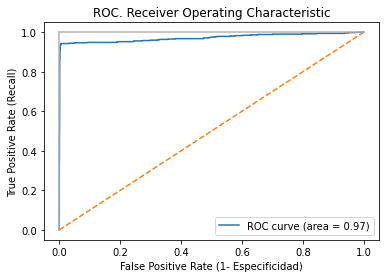

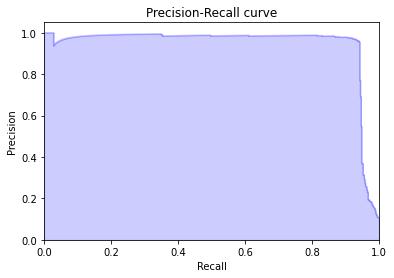

In [ ]:
# 4

visualizar_curva_ROC(modelo, X, y)

El área de la curva de ROC se comporta correctamente dado que alcanza el valor de 0.97, muy cercano al óptimo (1).

VISUALIZO LOS PARÁMETROS

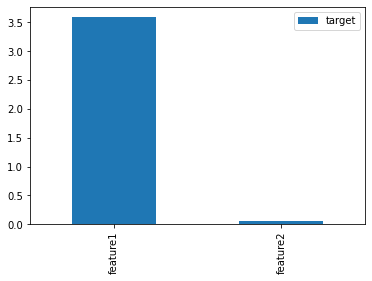

In [ ]:
# 1

visualizar_parametros(modelo, mostrar_bias=False, feature_names=X.columns, target_name=y.name)

FRONTERA DE DECISIÓN DE DOS DIMENSIONES

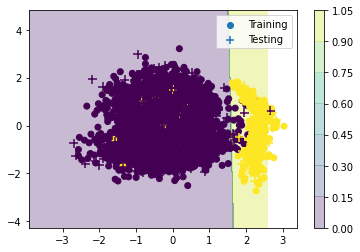


################################################

 CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH 

--------------------------------------- 



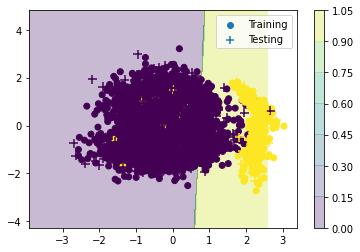

In [ ]:
# 5

visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test)

print("\n################################################")
print("\n CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH \n")
print("--------------------------------------- \n")

visualizar_frontera_de_desicion_2D(modelo_2, X, X_train, X_test, y_train, y_test)

FUNCION DE TRANSFERENCIA DE DOS DIMENSIONES

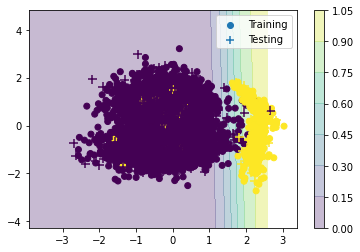


################################################

 CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH 

--------------------------------------- 



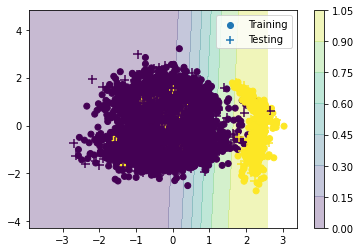

In [ ]:
# 5

visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test)

print("\n################################################")
print("\n CON CAMBIO EN EL PARAMETRO CLASS_WEIGTH \n")
print("--------------------------------------- \n")

visualizar_funcion_transferencia_2D(modelo_2, X, X_train, X_test, y_train, y_test)

Al cambiar el class_weight se observa como en estos últimos gráficos el modelo se corre para la izquierda, dándole mayor peso a la variable 1.

La **curva logística** del punto #6 con la función AA_utils.visualizar_curva_logistica no aplica en este ejercicio debido a que el modelo cuenta con mas de una features en la variable X.